In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon May  1 22:51:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
import numpy as np
import cv2
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
images = []
labels = []

In [8]:
# Load the FVC2000 dataset

train_dir = '/content/drive/MyDrive/Fingerprint/FVC2000_DB4_B/dataset/train_data'
for j in range(0, 10):
    for k in range(0, 80):
        path = '0000' + str(j) + '_';
        if k <= 9:
            path = path + '0';
        path = path + str(k) + '.bmp';
        img_path = os.path.join(train_dir, path)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Failed to read {img_path}")
            continue
        img = cv2.resize(img, (256, 256))
        img = np.expand_dims(img, axis=-1)

        images.append(img)
        labels.append(j)

In [9]:
images = np.array(images)
labels = np.array(labels)

In [10]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [11]:
IMAGE_SIZE = [256, 256, 3]
vgg = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [12]:
x = Flatten()(vgg.output)
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
# Train the model
history = model.fit(images, 
                    labels,
                    epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 16s 148ms/step - loss: 19.5064 - accuracy: 0.4087
Epoch 2/30
25/25 [==============================] - 4s 147ms/step - loss: 1.7364 - accuracy: 0.8925
Epoch 3/30
25/25 [==============================] - 4s 147ms/step - loss: 0.4159 - accuracy: 0.9588
Epoch 4/30
25/25 [==============================] - 4s 149ms/step - loss: 0.2629 - accuracy: 0.9800
Epoch 5/30
25/25 [==============================] - 4s 148ms/step - loss: 0.2245 - accuracy: 0.9825
Epoch 6/30
25/25 [==============================] - 4s 149ms/step - loss: 0.1617 - accuracy: 0.9800
Epoch 7/30
25/25 [==============================] - 4s 150ms/step - loss: 0.1733 - accuracy: 0.9850
Epoch 8/30
25/25 [==============================] - 4s 151ms/step - loss: 0.1372 - accuracy: 0.9887
Epoch 9/30
25/25 [==============================] - 4s 150ms/step - loss: 0.0957 - accuracy: 0.9937
Epoch 10/30
25/25 [==============================] - 4s 151ms/step - loss: 0.0216 - accuracy: 0.9962
Epoch 11

In [15]:
model.save('/content/drive/MyDrive/Fingerprint/FVC2000_DB4_B/Vgg16.h5')

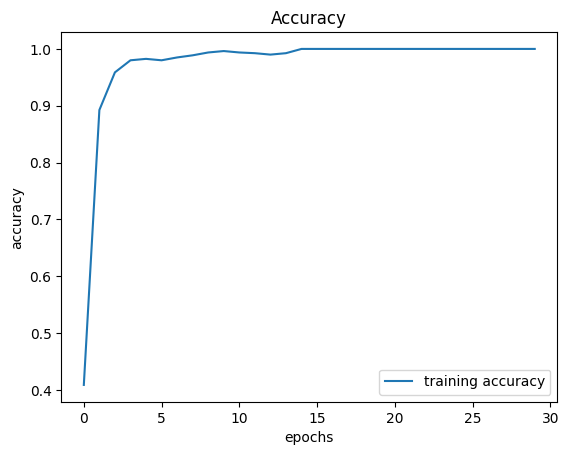

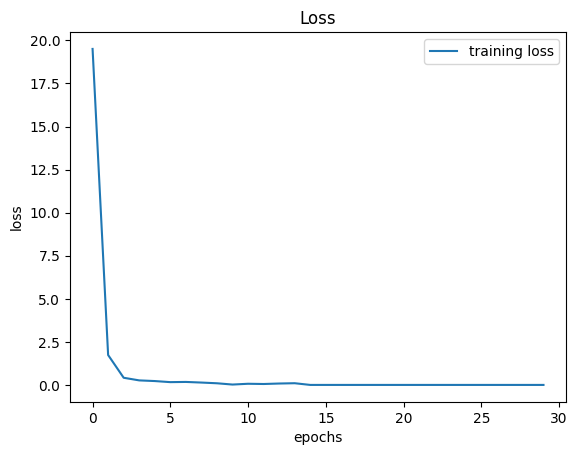

In [16]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
score = model.evaluate(images, labels, verbose=0)
print('accuracy:', score[1])

accuracy: 1.0
